In [1]:
import os

import tensorflow as tf
import numpy as np
import mrcnn.model
import mrcnn.utils 

from train import MRIConfig, MRIDataset

TEST_DATA_LIST = 'data/test_list.txt'
CLASSES = ['zdorovyj', 'patologiyu', 'patologicheskij']

dataset = MRIDataset()
dataset.load_mri(TEST_DATA_LIST, CLASSES)
dataset.prepare()

print('Images count: {}'.format(len(dataset.image_ids)))


Using TensorFlow backend.


Images count: 65


In [2]:
LOGS_DIR = 'logs'
MODEL_WEIGHTS_PATH = 'logs/mri20190402T1843//mask_rcnn_mri_0030.h5'
config = MRIConfig()
model = mrcnn.model.MaskRCNN(mode="inference", model_dir=LOGS_DIR, config=config)
model.load_weights(MODEL_WEIGHTS_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [3]:
from  matplotlib import pyplot as plt

aps = []
aps_c = [[] for i in range(len(CLASSES) + 1)]
precs = [[] for i in range(len(CLASSES) + 1)]
recs = [[] for i in range(len(CLASSES) + 1)]
for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask = mrcnn.model.load_image_gt(dataset, config, image_id)
    results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)[0]
    #print(gt_class_id.shape, gt_bbox.shape, results['rois'].shape, results['class_ids'].shape, 
    #      results['scores'].shape, results['masks'].shape)
    #print(gt_class_id[gt_class_id == 2], results['class_ids'][results['class_ids'] == 2])
    ap = mrcnn.utils.compute_ap(gt_bbox, gt_class_id, gt_mask, 
                                      results['rois'], results['class_ids'], results['scores'], 
                                      results['masks'])[0]
    aps.append(ap)
    
    for class_id in range(1, len(CLASSES) + 1):
        gt_ids = gt_class_id == class_id
        pred_ids = results['class_ids'] == class_id
        if np.sum(gt_ids) == 0:
            continue
        
        cap, prec, rec, overlaps = mrcnn.utils.compute_ap(gt_bbox[gt_ids], gt_class_id[gt_ids], gt_mask[:,:,gt_ids],
                                           results['rois'][pred_ids], results['class_ids'][pred_ids],
                                           results['scores'][pred_ids], results['masks'][:,:,pred_ids])
        aps_c[class_id].append(cap)
        precs[class_id].append(prec[-2])
        recs[class_id].append(rec[-2])
    
    
print('Mean AP@0.5: {:.3f}'.format(np.mean(aps)))
for i, cl in enumerate(CLASSES):
    print('{} mean AP@0.5: {:.3f}'.format(cl, np.mean(aps_c[i + 1])))
    print('Precision: {:.3f}, recall: {:.3f}'.format(np.mean(precs[i + 1]), np.mean(recs[i + 1])))

Mean AP@0.5: 0.511
zdorovyj mean AP@0.5: 0.566
Precision: 0.678, recall: 0.669
patologiyu mean AP@0.5: 0.025
Precision: 0.067, recall: 0.025
patologicheskij mean AP@0.5: 0.676
Precision: 0.760, recall: 0.716


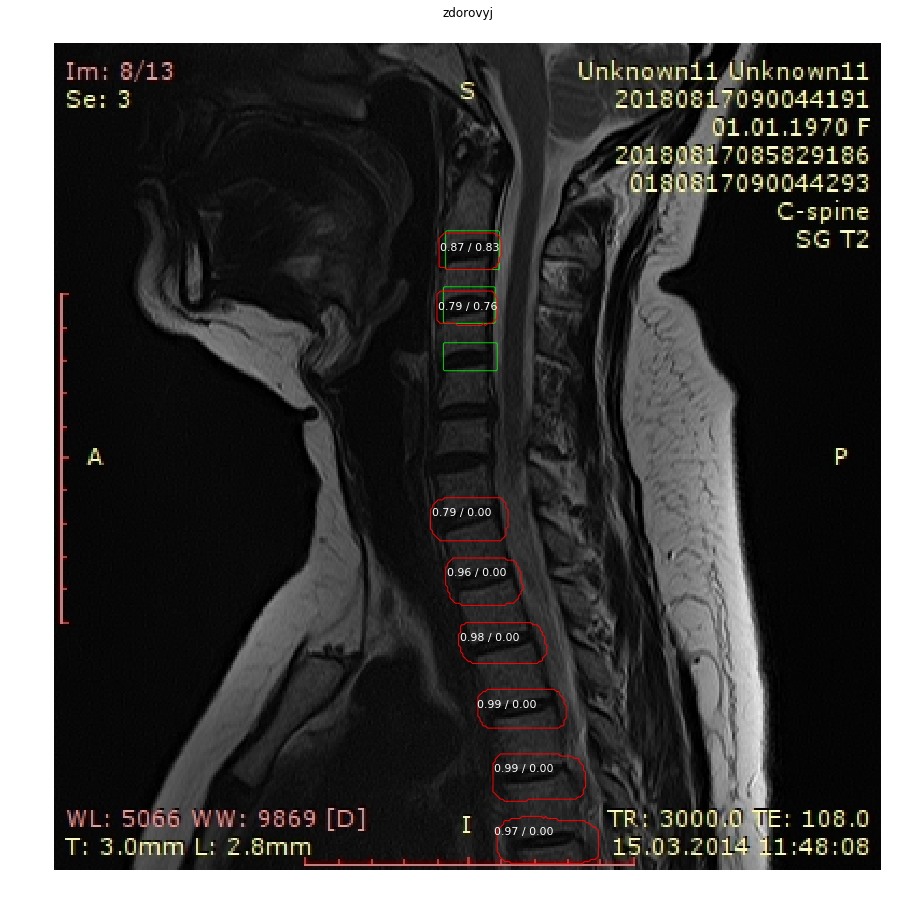

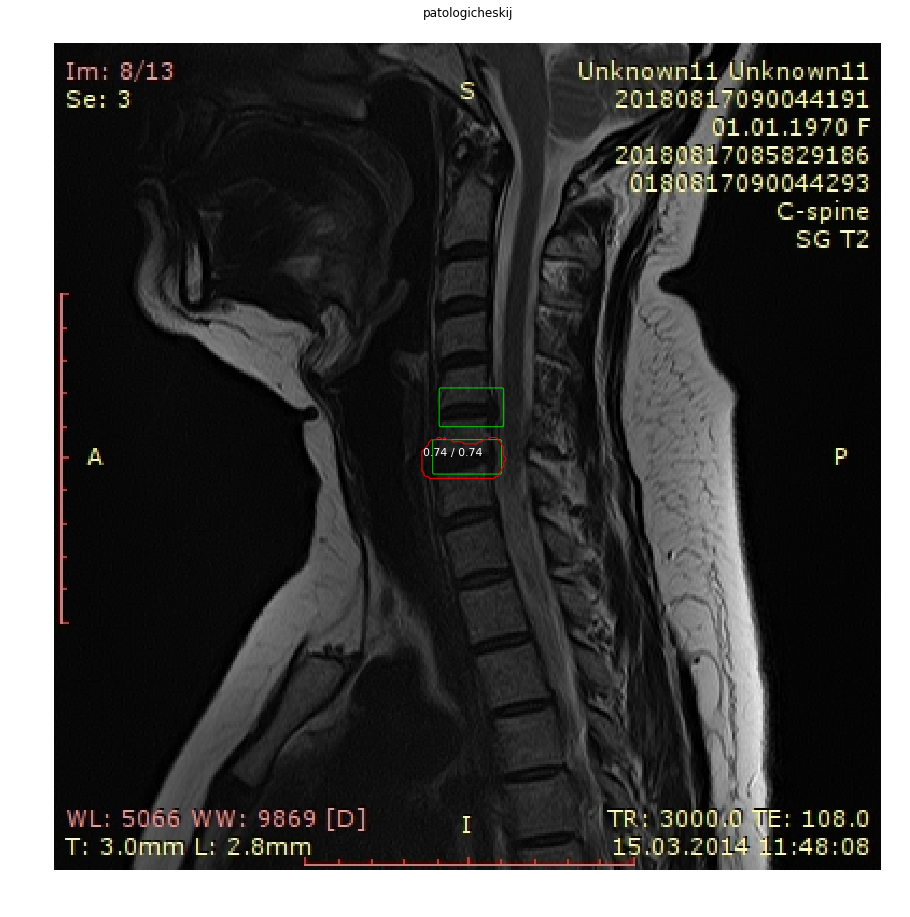

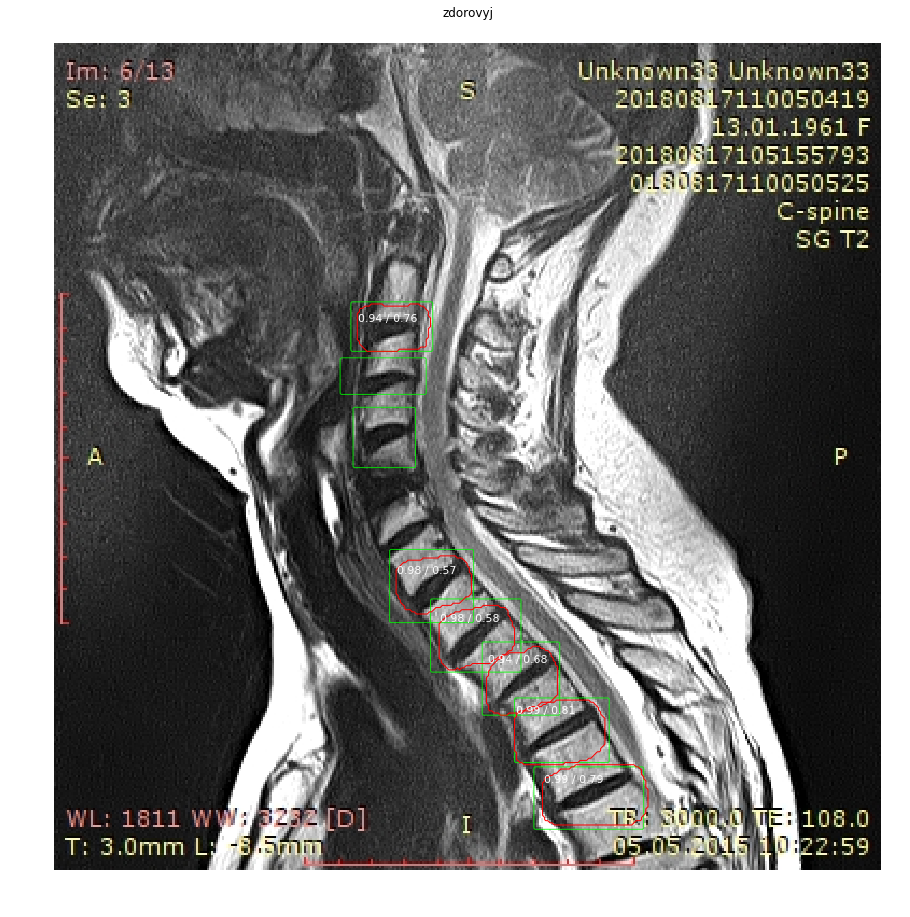

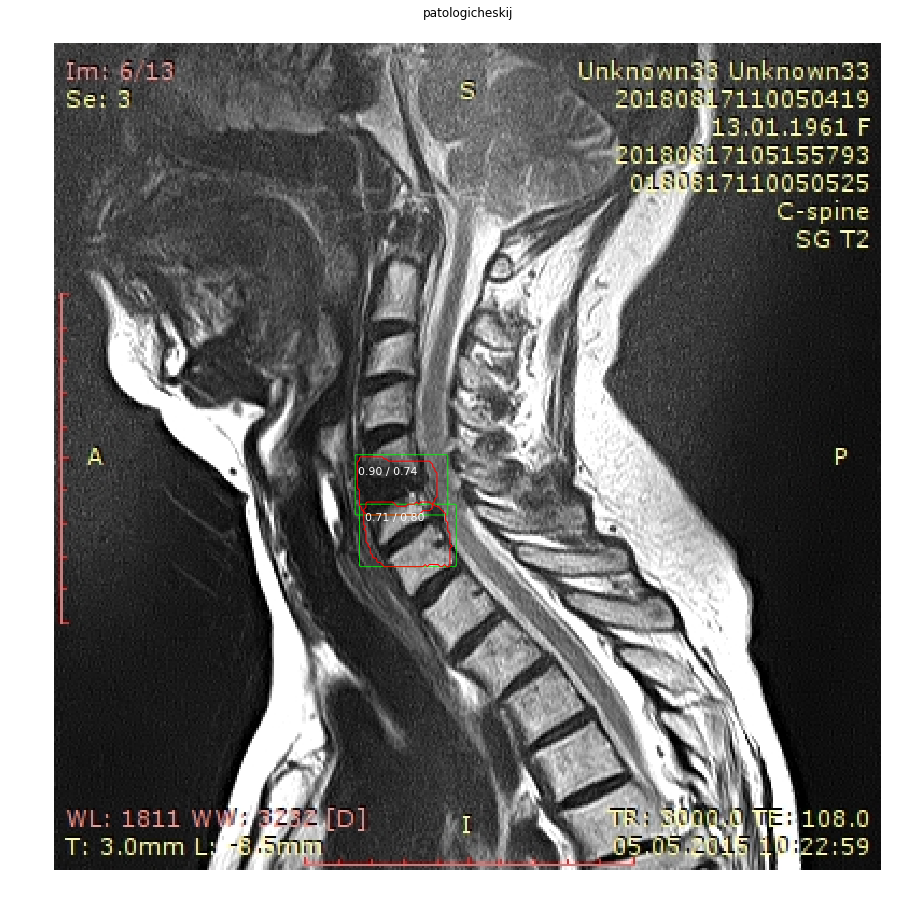

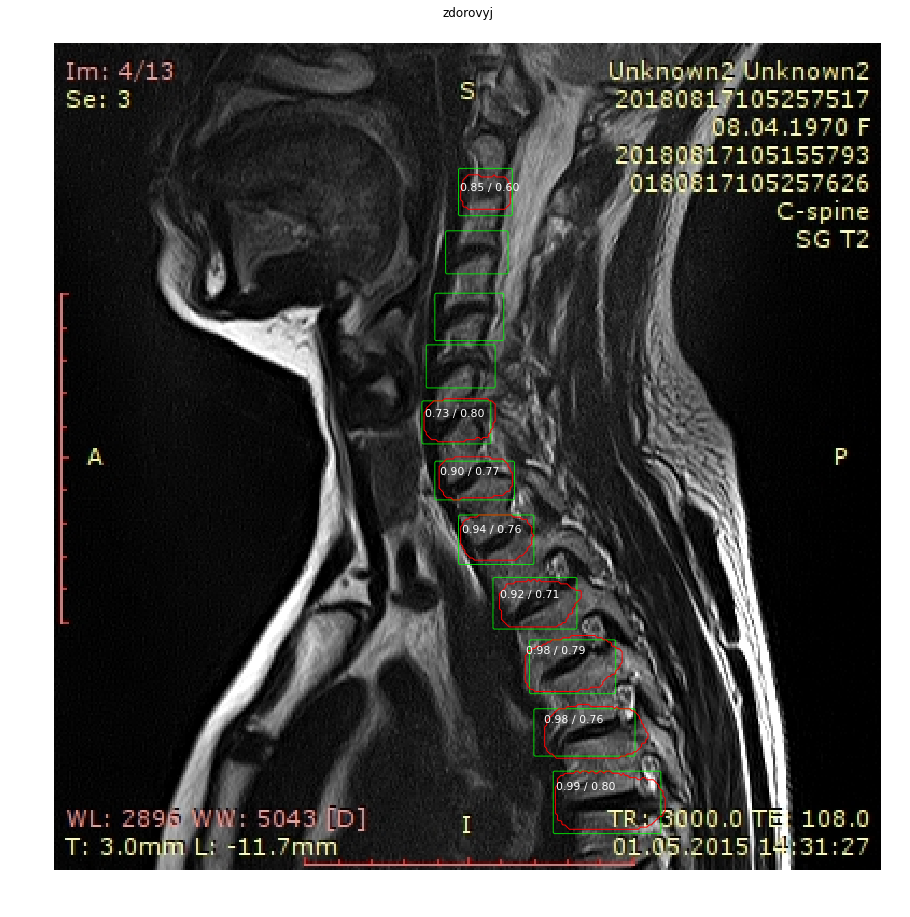

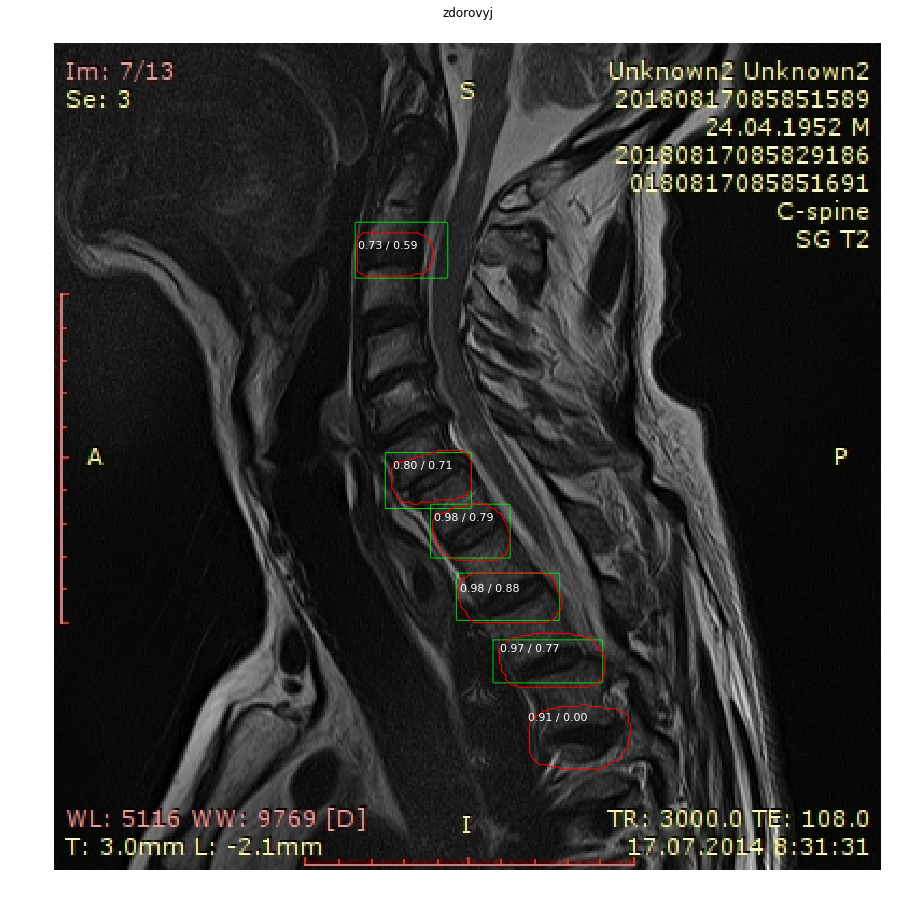

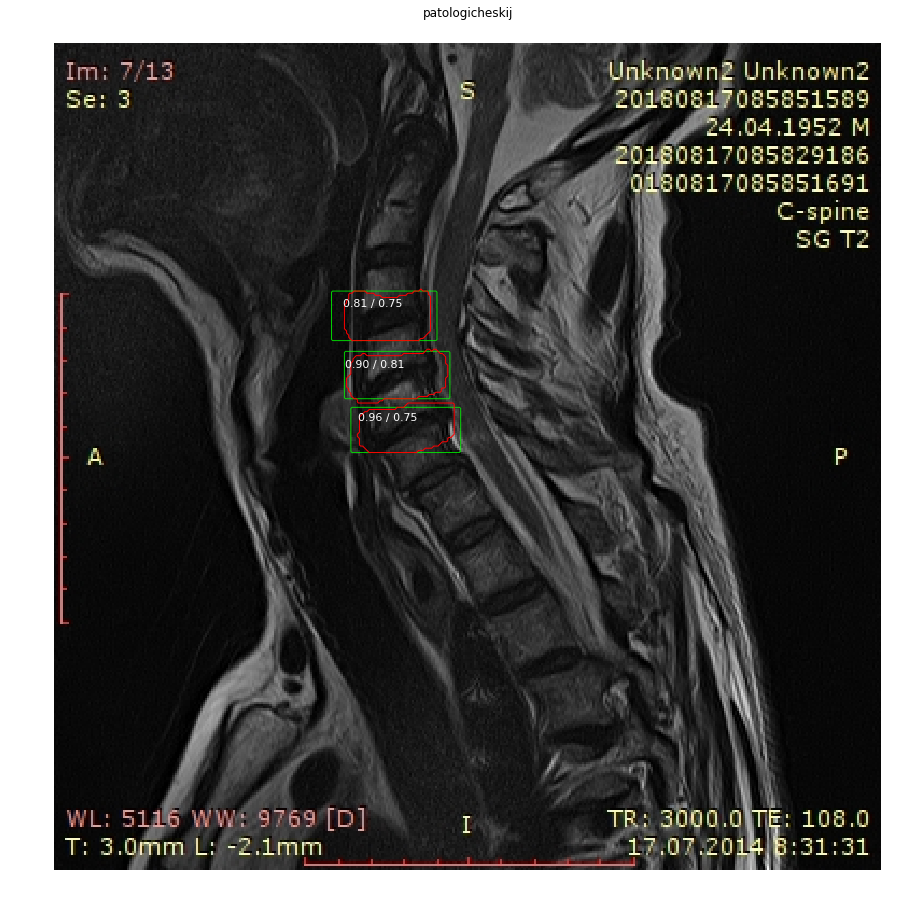

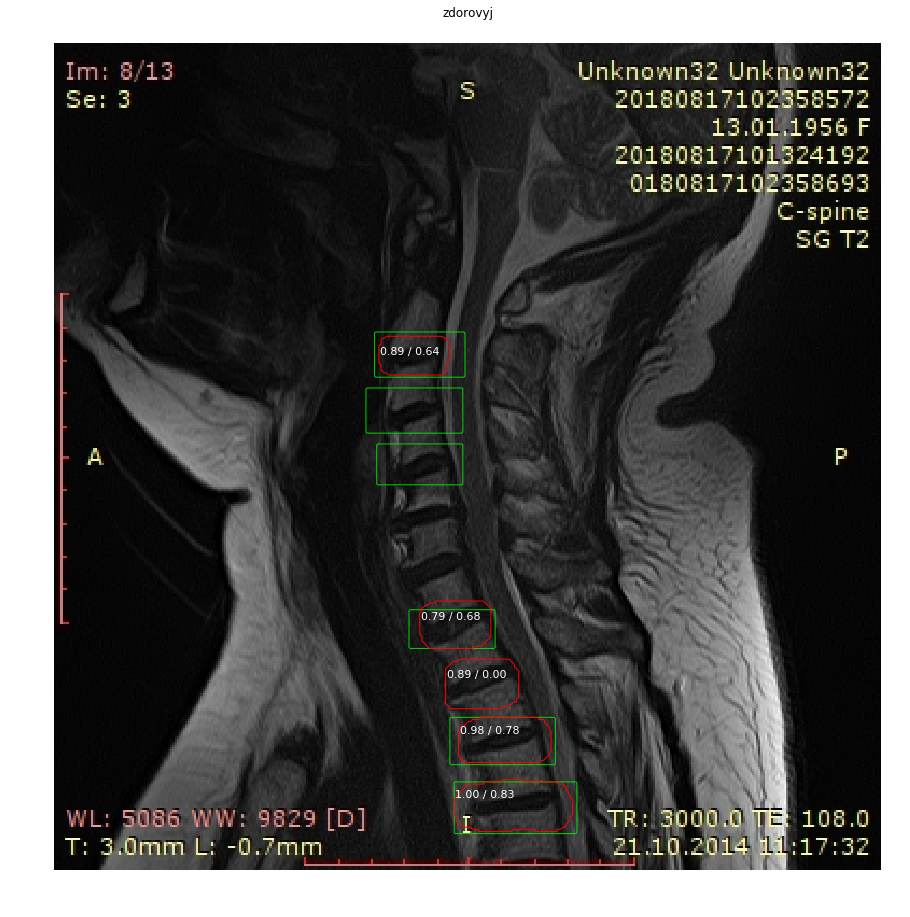

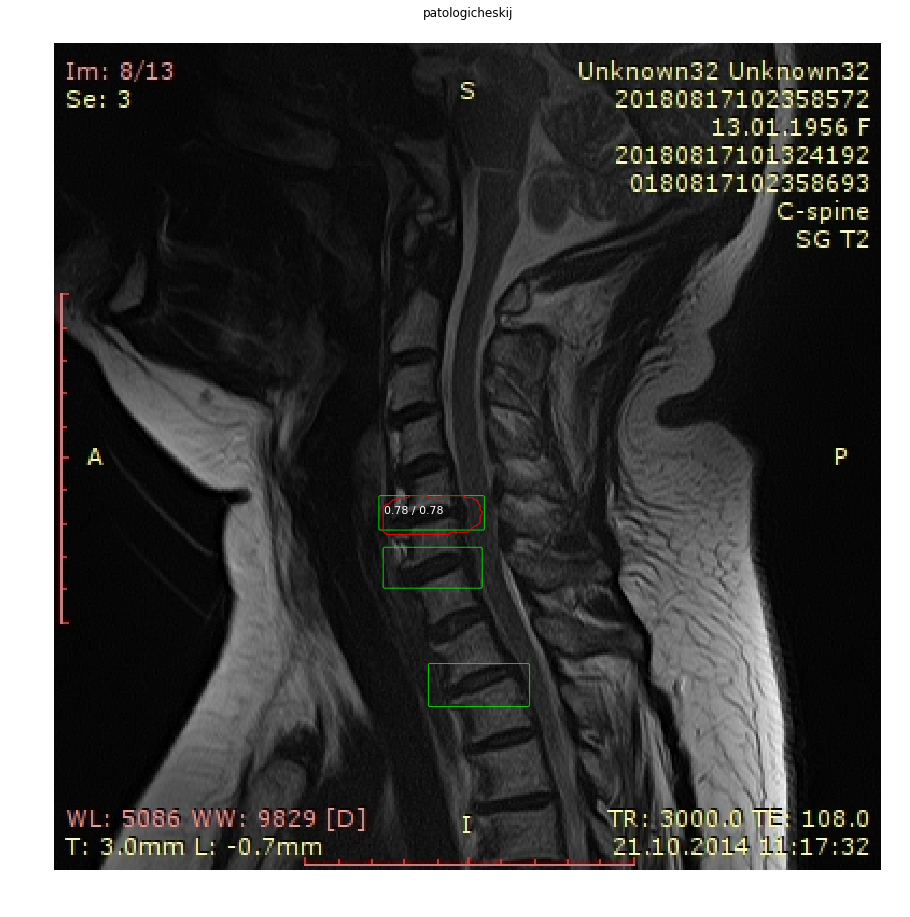

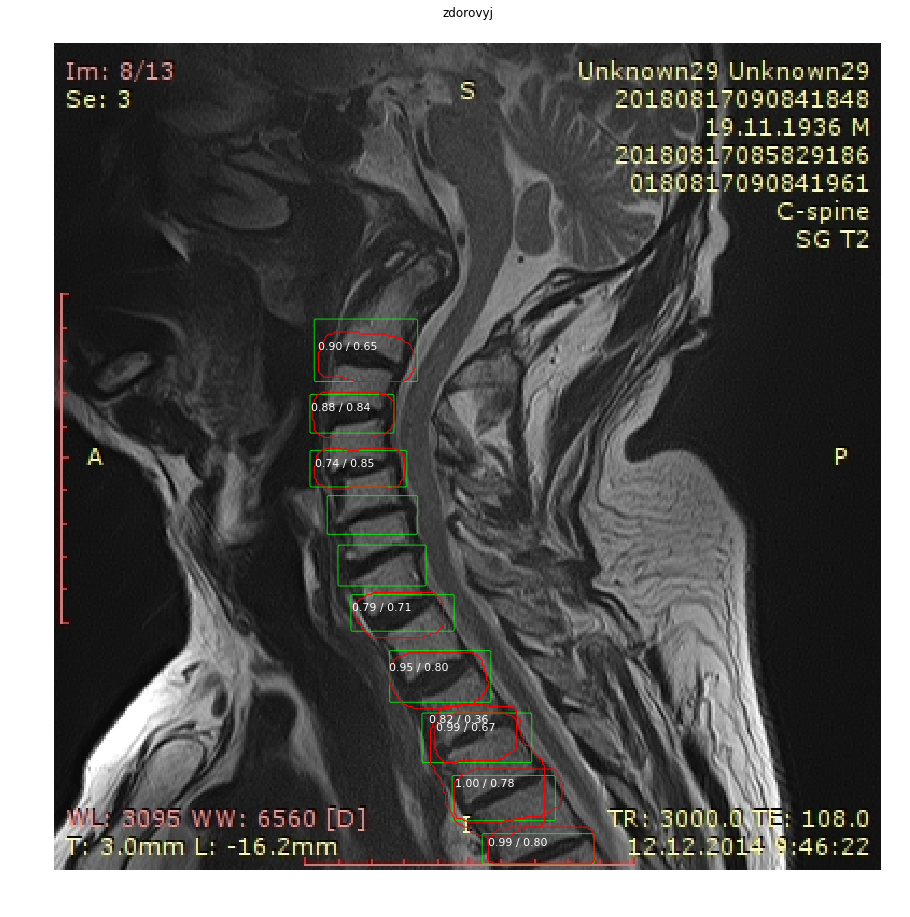

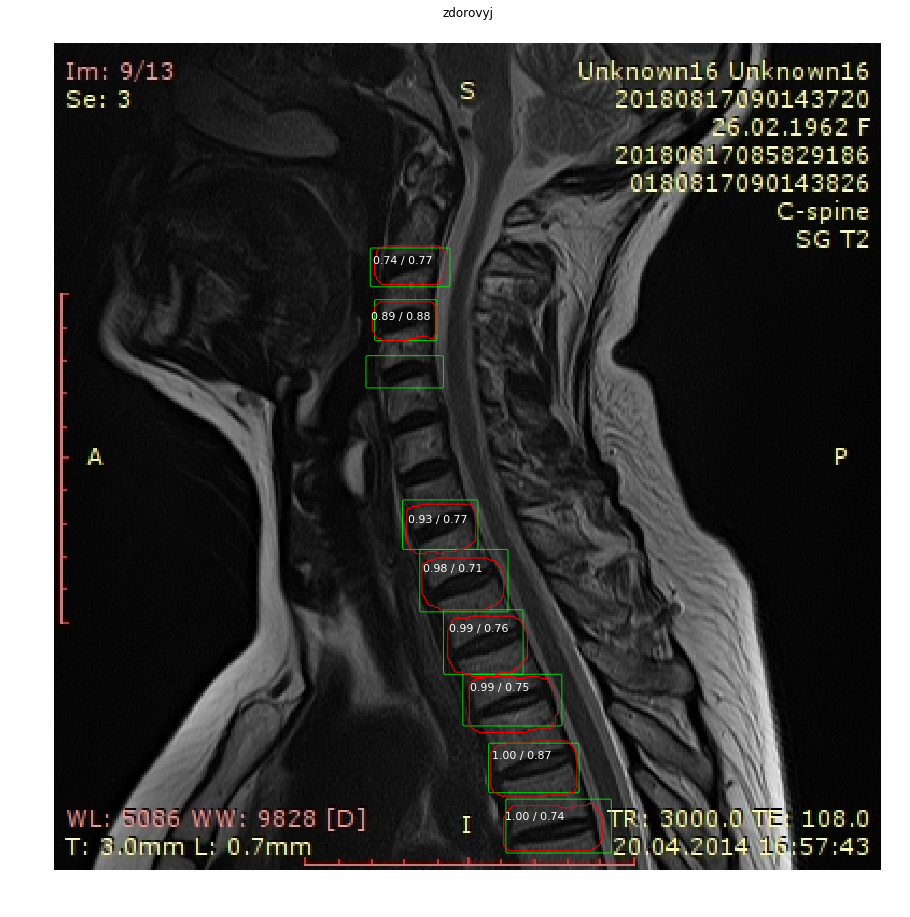

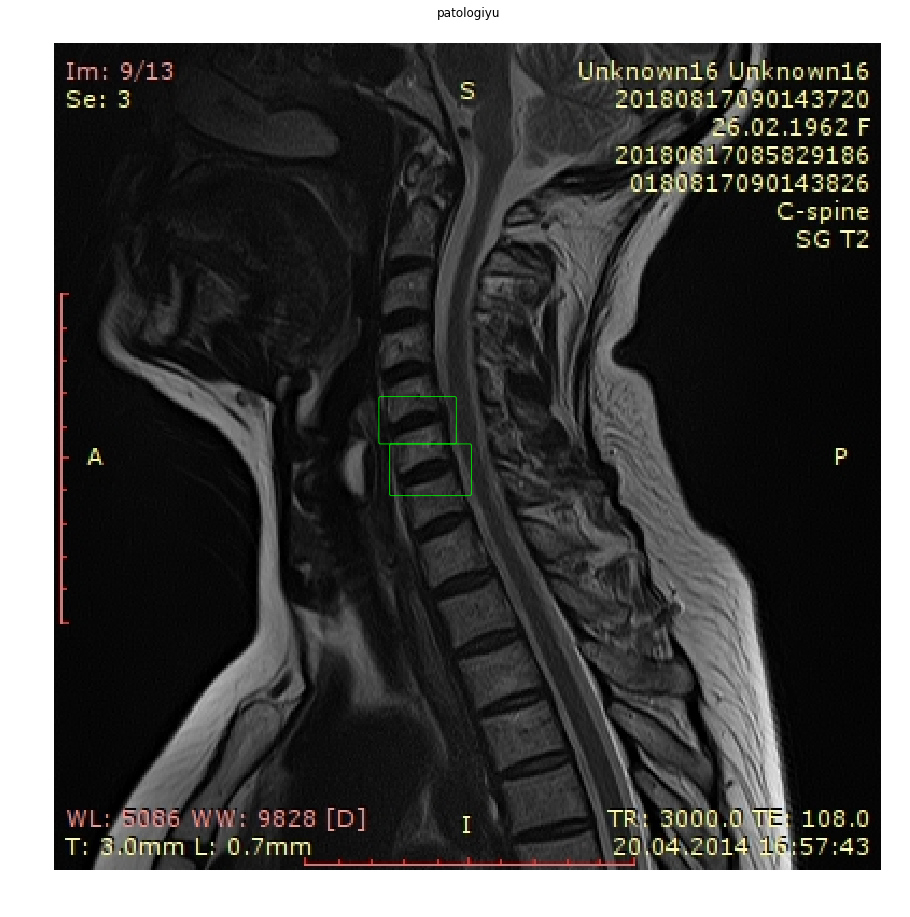

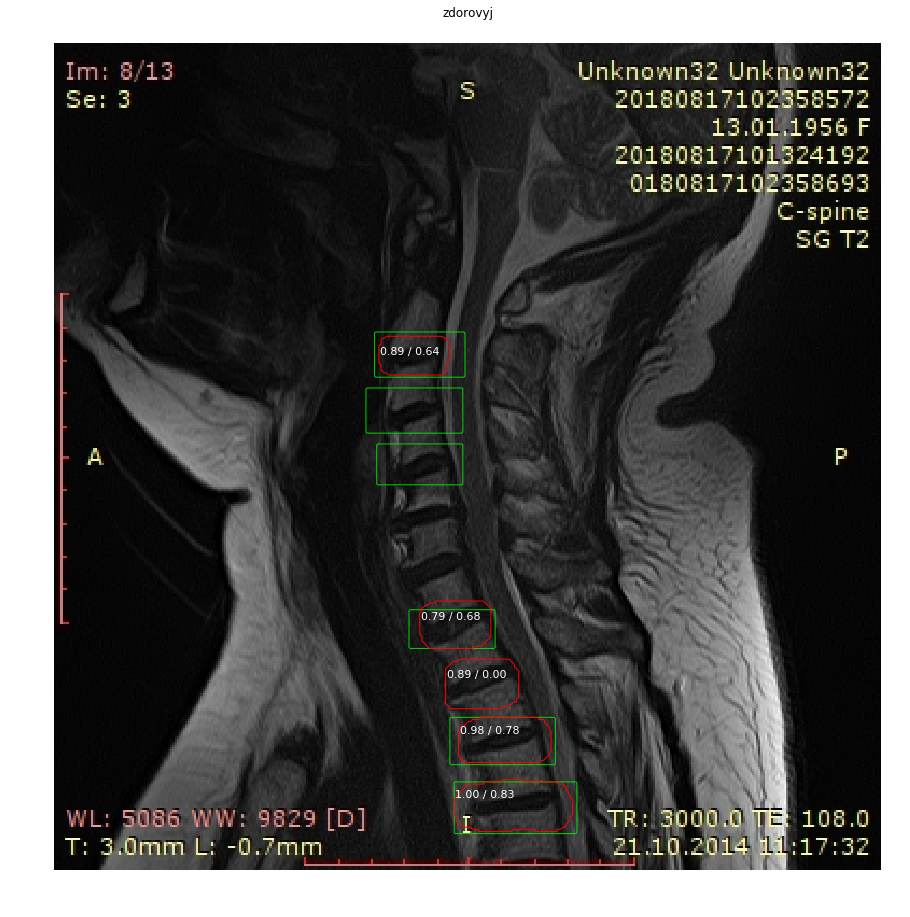

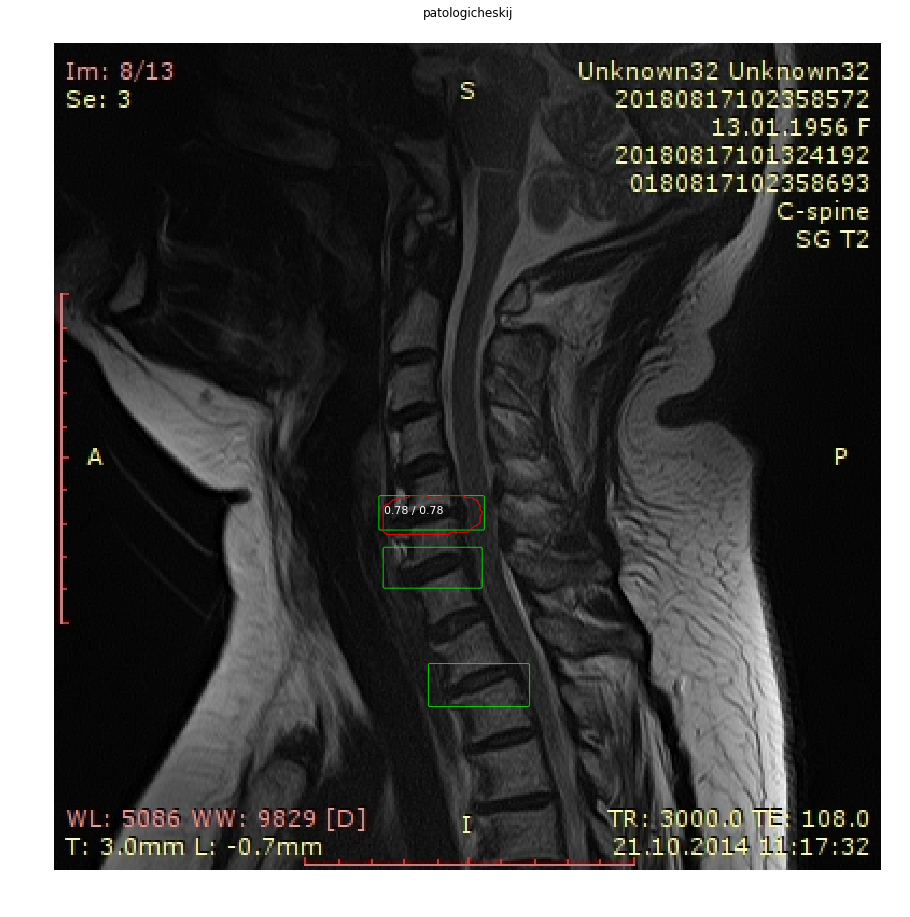

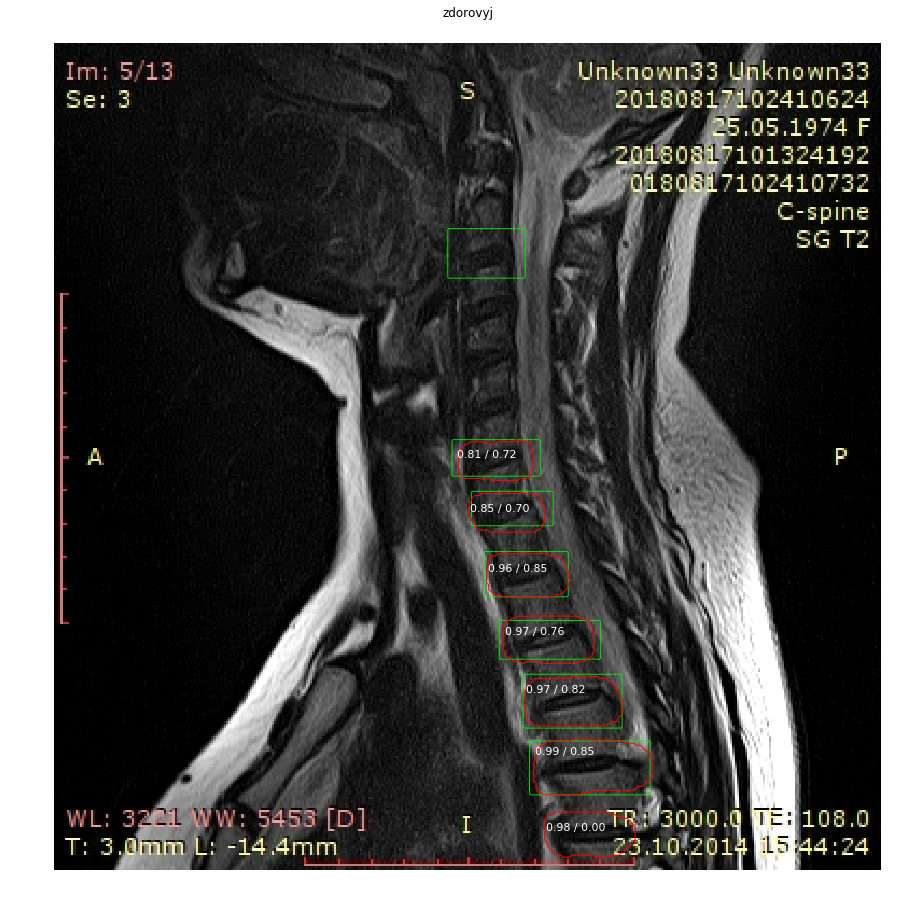

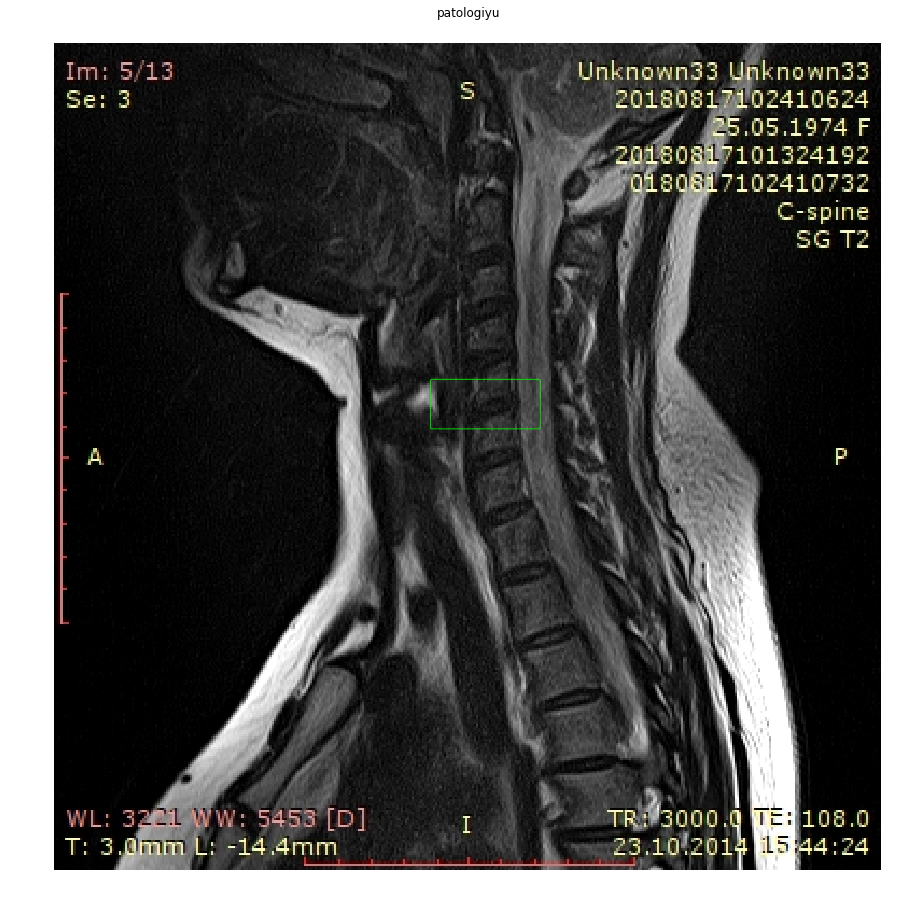

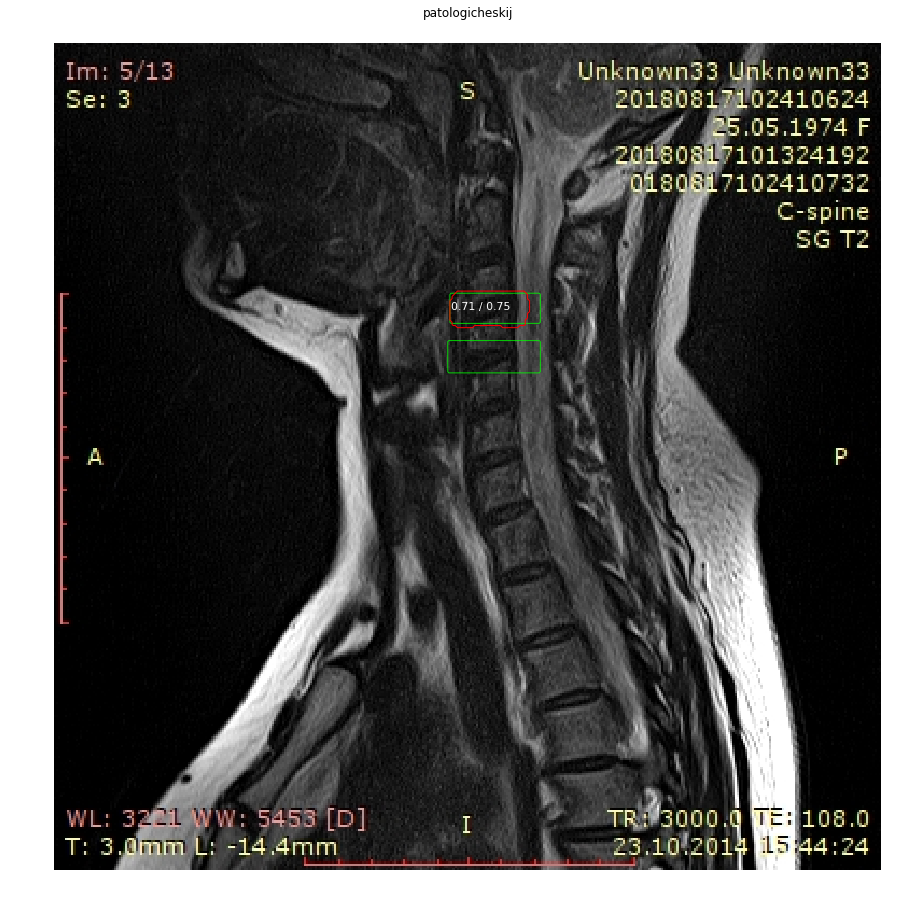

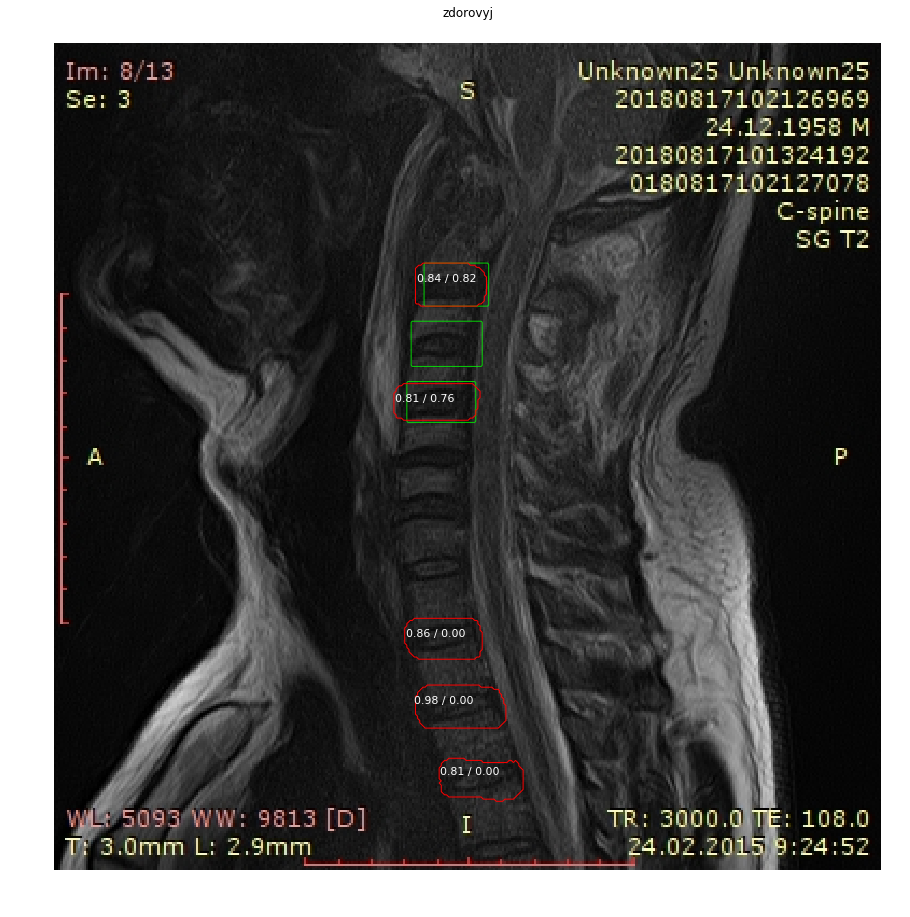

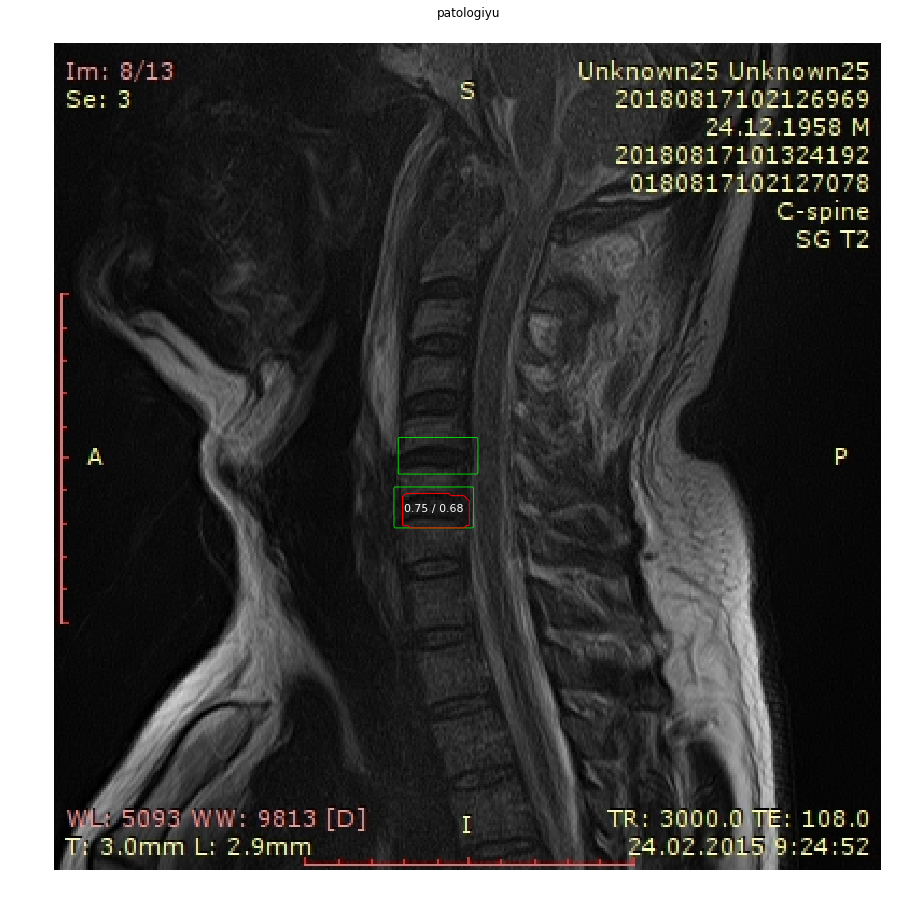

In [4]:
from  mrcnn import visualize
import random
random.seed(41)

for image_id in [random.choice(dataset.image_ids) for i in range(10)]:
    image, image_meta, gt_class_id, gt_bbox, gt_mask = mrcnn.model.load_image_gt(dataset, config, image_id)
    results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)[0]
    for i in range(0, len(CLASSES)):
        gt_ids = gt_class_id == i + 1
        pred_ids = results['class_ids'] == i + 1
        if np.sum(gt_ids) == 0:
            continue
        visualize.display_differences(image, gt_bbox[gt_ids], gt_class_id[gt_ids], gt_mask[:,:,gt_ids],
                                      results['rois'][pred_ids], results['class_ids'][pred_ids], 
                                      results['scores'][pred_ids], results['masks'][:,:,pred_ids], 
                                      dataset.class_names, show_mask=False, show_box=False,
                                        title=CLASSES[i])